In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 50

In [3]:
#import dataset
df_load = pd.read_csv('dqlab_telco.csv')

In [4]:
#Tampilkan jumlah baris dan kolom
print(df_load.shape)

(7113, 22)


In [5]:
#Tampilkan 5 data teratas
print(df_load.head(5))

   UpdatedAt   customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     202006  45759018157  Female              0     Yes         No     1.0   
1     202006  45557574145    Male              0      No         No    34.0   
2     202006  45366876421    Male              0      No         No     2.0   
3     202006  45779536532    Male              0      No         No    45.0   
4     202006  45923787906  Female              0      No         No     2.0   

  PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0           No  No phone service             DSL             No          Yes   
1          Yes                No             DSL            Yes           No   
2          Yes                No             DSL            Yes          Yes   
3           No  No phone service             DSL            Yes           No   
4          Yes                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV S

In [6]:
#Jumlah ID yang unik
print(df_load.customerID.nunique())

7017


In [7]:
#Memfilter ID Number Pelanggan
"""
Kriteria:
- Panjang karakter adalah 11-12.
- Terdiri dari Angka Saja, tidak diperbolehkan ada karakter selain angka
- Diawali dengan angka 45 2 digit pertama.
"""

df_load['valid_id']=df_load['customerID'].astype(str).str.match(r'(45\d{9,10})')
df_load=(df_load[df_load['valid_id']==True]).drop('valid_id', axis=1)
print('Hasil jumlah ID Customer yang terfilter adalah',df_load['customerID'].count())

Hasil jumlah ID Customer yang terfilter adalah 7006


In [8]:
#Memfilter Duplikasi ID Number Pelanggan
"""
Penyebab duplikasi:
- inserting melebihi satu kali dengan nilai yang sama tiap kolomnya
- inserting beda periode pengambilan data
"""

#Menghapus nilai duplikat
df_load.drop_duplicates()

#Menghapus nilai duplikat ID yang diurutkan berdasarkan Periode
df_load=df_load.sort_values('UpdatedAt',ascending=False).drop_duplicates(['customerID'])
print('Hasil jumlah ID Customer yang sudah dihilangkan duplikasinya (distinct) adalah',df_load['customerID'].count())

Hasil jumlah ID Customer yang sudah dihilangkan duplikasinya (distinct) adalah 6993


In [9]:
#Mengatasi Missing Values dengan Penghapusan Rows
"""
Di asumsikan data modeller hanya mau menerima data yang benar ada flag churn nya atau tidak.
"""

print('Total missing values data dari kolom Churn',df_load['Churn'].isnull().sum())

Total missing values data dari kolom Churn 43


In [10]:
#Menghapus semua missing value pada kolom churn
df_load.dropna(subset=['Churn'],inplace=True)

print('Total Rows dan kolom Data setelah dihapus data Missing Values adalah',df_load.shape)

Total Rows dan kolom Data setelah dihapus data Missing Values adalah (6950, 22)


In [11]:
#Mengatasi missing value dengan pengisian nilai tertentu pada kolom numerik
"""
Diasumsikan data modeller meminta pengisian missing values dengan kriteria:
- Tenure pihak data modeller meminta setiap rows yang memiliki missing values untuk Lama berlangganan di isi dengan 11
- Variable yang bersifat numeric selain Tenure di isi dengan median dari masing-masing variable tersebut
"""

print('Status Missing Values:',df_load.isnull().values.any())
print('\nJumlah Missing Values masing-masing kolom, adalah:')
print(df_load.isnull().sum().sort_values(ascending=False))

Status Missing Values: True

Jumlah Missing Values masing-masing kolom, adalah:
tenure              99
MonthlyCharges      26
TotalCharges        15
Churn                0
InternetService      0
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
PhoneService         0
MultipleLines        0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
UpdatedAt            0
dtype: int64


In [12]:
#handling missing values Tenure fill with 11
df_load['tenure'].fillna(11, inplace=True)

In [13]:
#Handling missing values num vars (except Tenure)
for col_name in list(['MonthlyCharges','TotalCharges']):
	median=df_load[col_name].median()
	df_load[col_name].fillna(median, inplace=True)

print('\nJumlah Missing Values setelah di imputer datanya, adalah:')
print(df_load.isnull().sum().sort_values(ascending=False))


Jumlah Missing Values setelah di imputer datanya, adalah:
Churn               0
TotalCharges        0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
UpdatedAt           0
dtype: int64


In [14]:
#Mendeteksi adanya Outlier (Boxplot)
print('\nPersebaran data sebelum ditangani Outlier: ')
print(df_load[['tenure','MonthlyCharges','TotalCharges']].describe())


Persebaran data sebelum ditangani Outlier: 
            tenure  MonthlyCharges  TotalCharges
count  6950.000000     6950.000000   6950.000000
mean     32.477266       65.783741   2305.083460
std      25.188910       50.457871   2578.651143
min       0.000000        0.000000     19.000000
25%       9.000000       36.462500    406.975000
50%      29.000000       70.450000   1400.850000
75%      55.000000       89.850000   3799.837500
max     500.000000     2311.000000  80000.000000


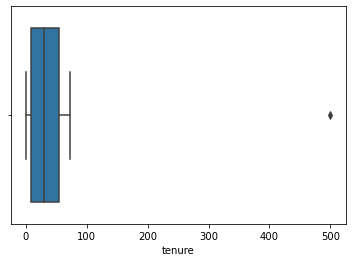

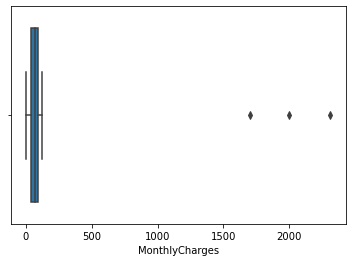

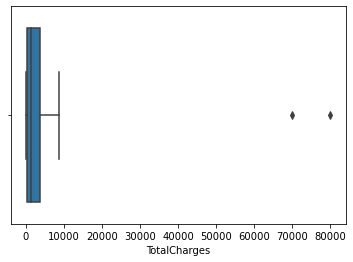

In [15]:
#Membuat Box Plot
#Masukkan variabel numerik
plt.figure()
sns.boxplot(x=df_load['tenure'])
plt.show()

plt.figure()
sns.boxplot(x=df_load['MonthlyCharges'])
plt.show()

plt.figure()
sns.boxplot(x=df_load['TotalCharges'])
plt.show()

In [16]:
#Mengatasi outlier dengan metode Inter Quartile Range (IQR)
"""
Tentukan:
- Nilai Minimum dan Maximum data di tolerir
- Ubah Nilai yg di luar Range Minumum & Maximum ke dalam nilai Minimum dan Maximum
"""

Q1 = (df_load[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.25)
Q3 = (df_load[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.75)
IQR = Q3 - Q1
maximum = Q3 + (1.5*IQR)
print('Nilai Maximum dari masing-masing Variable adalah: ')
print(maximum)
minimum = Q1 - (1.5*IQR)
print('\nNilai Minimum dari masing-masing Variable adalah: ')
print(minimum)
more_than = (df_load > maximum)
lower_than = (df_load < minimum)
df_load = df_load.mask(more_than, maximum, axis=1)
df_load = df_load.mask(lower_than, minimum, axis=1)
print('\nPersebaran data setelah ditangani Outlier: ')
print(df_load[['tenure','MonthlyCharges','TotalCharges']].describe())

Nilai Maximum dari masing-masing Variable adalah: 
tenure             124.00000
MonthlyCharges     169.93125
TotalCharges      8889.13125
dtype: float64

Nilai Minimum dari masing-masing Variable adalah: 
tenure             -60.00000
MonthlyCharges     -43.61875
TotalCharges     -4682.31875
dtype: float64

Persebaran data setelah ditangani Outlier: 
            tenure  MonthlyCharges  TotalCharges
count  6950.000000     6950.000000   6950.000000
mean     32.423165       64.992201   2286.058750
std      24.581073       30.032040   2265.702553
min       0.000000        0.000000     19.000000
25%       9.000000       36.462500    406.975000
50%      29.000000       70.450000   1400.850000
75%      55.000000       89.850000   3799.837500
max     124.000000      169.931250   8889.131250


In [17]:
#Mendeteksi Nilai yang tidak Standar
for col_name in list(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Churn']):
	print('\nUnique Values Count \033[1m'+'Before Standardized \033[0m Variable',col_name)
	print(df_load[col_name].value_counts())


Unique Values Count Before Standardized  Variable gender
Male         3499
Female       3431
Wanita         14
Laki-Laki       6
Name: gender, dtype: int64

Unique Values Count Before Standardized  Variable SeniorCitizen
0    5822
1    1128
Name: SeniorCitizen, dtype: int64

Unique Values Count Before Standardized  Variable Partner
No     3591
Yes    3359
Name: Partner, dtype: int64

Unique Values Count Before Standardized  Variable Dependents
No     4870
Yes    2060
Iya      20
Name: Dependents, dtype: int64

Unique Values Count Before Standardized  Variable PhoneService
Yes    6281
No      669
Name: PhoneService, dtype: int64

Unique Values Count Before Standardized  Variable MultipleLines
No                  3346
Yes                 2935
No phone service     669
Name: MultipleLines, dtype: int64

Unique Values Count Before Standardized  Variable InternetService
Fiber optic    3057
DSL            2388
No             1505
Name: InternetService, dtype: int64

Unique Values Count Befor

In [19]:
#Menstandarisasi Variable Kategorik
df_load = df_load.replace(['Wanita','Laki-Laki','Churn','Iya'],['Female','Male','Yes','Yes'])

for col_name in list(['gender','Dependents','Churn']):
	print('\nUnique Values Count \033[1m' + 'After Standardized \033[0mVariable',col_name)
	print(df_load[col_name].value_counts())


Unique Values Count After Standardized Variable gender
Male      3505
Female    3445
Name: gender, dtype: int64

Unique Values Count After Standardized Variable Dependents
No     4870
Yes    2080
Name: Dependents, dtype: int64

Unique Values Count After Standardized Variable Churn
No     5114
Yes    1836
Name: Churn, dtype: int64


## Exploratory data analysis

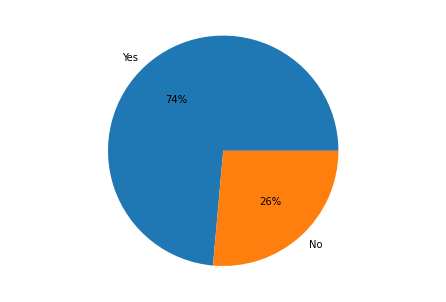

In [20]:
#Memvisualisasikan Prosentase Churn
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['Yes','No']
churn = df_load.Churn.value_counts()
ax.pie(churn, labels=labels, autopct='%.0f%%')
plt.show()

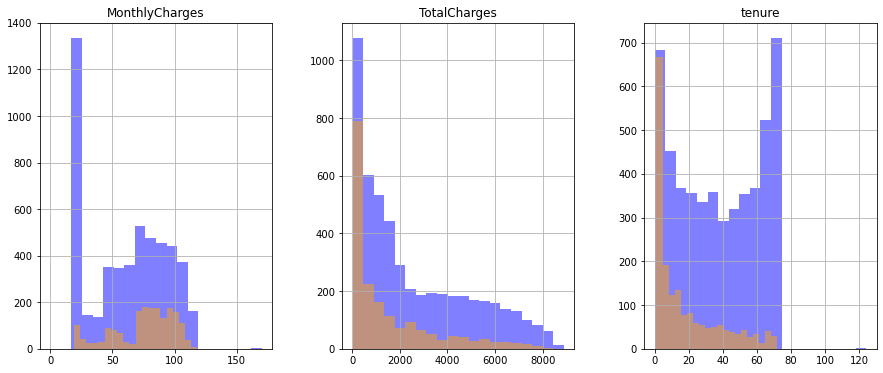

In [22]:
#EDA Variabel Numerik (Prediktor)
#Membuat bin dalam grafik
numerical_features = ['MonthlyCharges','TotalCharges','tenure']
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

#Membuat grafik tiap variabel dalam numerical_features dengan overlay warna biru (Tidak churn) dan orange (Churn)
df_load[df_load.Churn == 'No'][numerical_features].hist(bins=20, color='blue', alpha=0.5, ax=ax)
df_load[df_load.Churn == 'Yes'][numerical_features].hist(bins=20, color='orange', alpha=0.5, ax=ax)
plt.show()

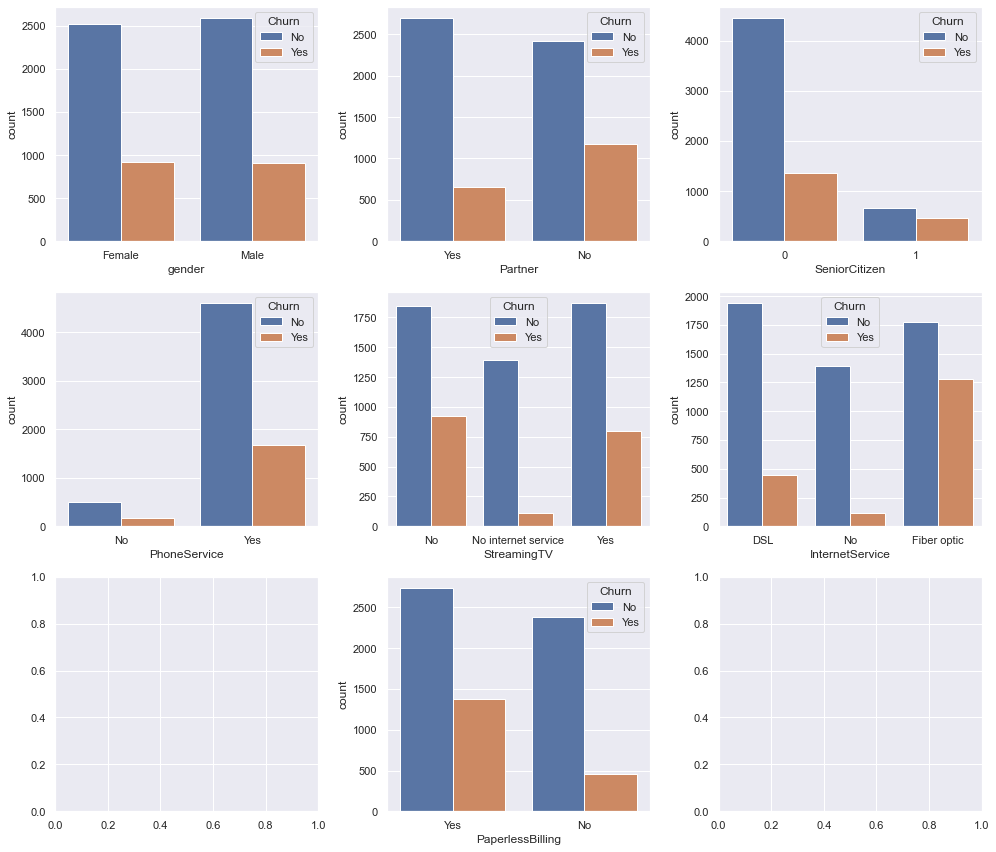

In [23]:
#EDA Variabel Kategorik (Prediktor)
sns.set(style='darkgrid')
fig, ax = plt.subplots(3, 3, figsize=(14, 12))
sns.countplot(data=df_load, x='gender', hue='Churn', ax=ax[0][0])
sns.countplot(data=df_load, x='Partner', hue='Churn', ax=ax[0][1])
sns.countplot(data=df_load, x='SeniorCitizen', hue='Churn', ax=ax[0][2])
sns.countplot(data=df_load, x='PhoneService', hue='Churn', ax=ax[1][0])
sns.countplot(data=df_load, x='StreamingTV', hue='Churn', ax=ax[1][1])
sns.countplot(data=df_load, x='InternetService', hue='Churn', ax=ax[1][2])
sns.countplot(data=df_load, x='PaperlessBilling', hue='Churn', ax=ax[2][1])
plt.tight_layout()
plt.show()

## Data pre-processing 

In [24]:
#Menghapus Unnecessary Columns (customerID, UpdatedAt) dari data
cleaned_df=df_load.drop(['customerID','UpdatedAt'], axis=1)
print(cleaned_df.head())

      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     Female              0     Yes         No     1.0           No   
4727    Male              0     Yes         No    60.0          Yes   
4738    Male              0      No         No     5.0          Yes   
4737  Female              0     Yes         No    72.0          Yes   
4736  Female              0     Yes        Yes    56.0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
0     No phone service             DSL                   No   
4727                No              No  No internet service   
4738               Yes     Fiber optic                   No   
4737               Yes     Fiber optic                  Yes   
4736               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
0                     Yes                   No                   No   
4727  No internet service  No internet service  No i

In [28]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [29]:
#Encoding Data
for column in cleaned_df.columns:
	if cleaned_df[column].dtype == np.number: continue #jika data sudah numerik maka diabaikan
	# Mengubah setiap data non-numerik menjadi numerik
	cleaned_df[column] = LabelEncoder().fit_transform(cleaned_df[column])
print(cleaned_df.describe())

            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  6950.000000    6950.000000  6950.000000  6950.000000  6950.000000   
mean      0.504317       0.162302     0.483309     0.299281    32.423165   
std       0.500017       0.368754     0.499757     0.457976    24.581073   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000   124.000000   

       PhoneService  MultipleLines  InternetService  OnlineSecurity  \
count   6950.000000    6950.000000      6950.000000     6950.000000   
mean       0.903741       0.940863         0.872950        0.789496   
std        0.294967       0.948880         0.737618        0.859795   
min        0.000000       0.000

<ipython-input-29-e71f5b832377>:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if cleaned_df[column].dtype == np.number: continue #jika data sudah numerik maka diabaikan


In [31]:
# Predictor (X) dan target (y)
X = cleaned_df.drop('Churn', axis=1)
y = cleaned_df['Churn']

In [32]:
# membagi menjadi train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Jumlah baris dan kolom dari x_train adalah:',x_train.shape,', sedangkan Jumlah baris dan kolom dari y_train adalah:',y_train.shape)
print('Prosentase Churn di data Training adalah:')
print(y_train.value_counts(normalize=True))
print('Jumlah baris dan kolom dari x_test adalah:',x_test.shape,', sedangkan Jumlah baris dan kolom dari y_test adalah:',y_test.shape)
print('Prosentase Churn di data Testing adalah:')
print(y_test.value_counts(normalize=True))

Jumlah baris dan kolom dari x_train adalah: (4865, 19) , sedangkan Jumlah baris dan kolom dari y_train adalah: (4865,)
Prosentase Churn di data Training adalah:
0    0.734841
1    0.265159
Name: Churn, dtype: float64
Jumlah baris dan kolom dari x_test adalah: (2085, 19) , sedangkan Jumlah baris dan kolom dari y_test adalah: (2085,)
Prosentase Churn di data Testing adalah:
0    0.738129
1    0.261871
Name: Churn, dtype: float64


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report

## Logistic Regression Model

In [35]:
#Train model
log_model=LogisticRegression().fit(x_train,y_train)
print('Model Logistic Regression yang terbentuk adalah: \n', log_model)

Model Logistic Regression yang terbentuk adalah: 
 LogisticRegression()


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
#Performansi Model Training - Menampilkan Metrics

# Prediksi
y_train_pred = log_model.predict(x_train)

# Print classification report
print('Classification Report Training Model (Logistic Regression) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      3575
           1       0.64      0.56      0.60      1290

    accuracy                           0.80      4865
   macro avg       0.74      0.72      0.73      4865
weighted avg       0.79      0.80      0.80      4865



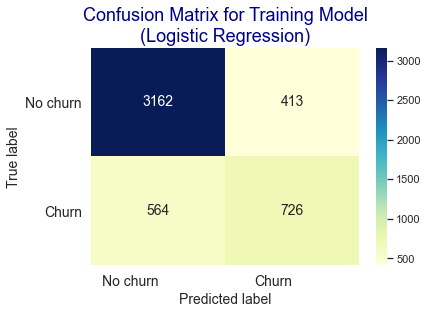

In [37]:
#Performansi Model Training - Menampilkan Plots

#Mengubah confusion matrix menjadi DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Training Model\n(Logistic Regression)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [38]:
#Performansi Model Testing - Menampilkan Metrics

# Prediksi
y_test_pred = log_model.predict(x_test)

# Print classification report
print('Classification Report Testing Model (Logistic Regression) :')
print(classification_report(y_test,y_test_pred))

Classification Report Testing Model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1539
           1       0.66      0.54      0.60       546

    accuracy                           0.81      2085
   macro avg       0.76      0.72      0.74      2085
weighted avg       0.80      0.81      0.80      2085



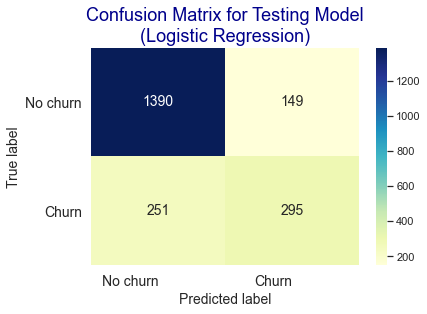

In [39]:
#Performansi Model Training - Menampilkan Plots

# Mengubah confusion matrix menjadi DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

## Random Forest Classifier

In [40]:
#Train model
rdf_model = RandomForestClassifier().fit(x_train,y_train)
print(rdf_model)

RandomForestClassifier()


In [41]:
#Performansi Data Training - Menampilkan Metrics
y_train_pred = rdf_model.predict(x_train)
print('Classification Report Training Model (Random Forest) :')
print(classification_report(y_train, y_train_pred))

Classification Report Training Model (Random Forest) :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      0.99      0.99      1290

    accuracy                           1.00      4865
   macro avg       1.00      1.00      1.00      4865
weighted avg       1.00      1.00      1.00      4865



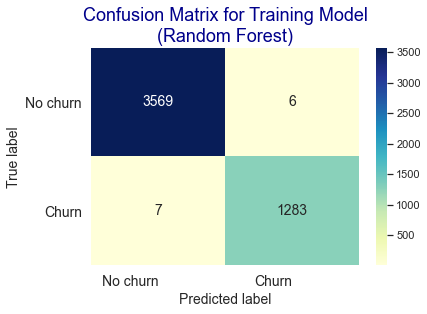

In [42]:
#Performansi Data Training - Menampilkan Plots

#Mengubah bentuk confusion matrix menjadi DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train,y_train_pred)), ('No churn','Churn'), ('No churn','Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Training Model\n(Random Forest)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()


In [43]:
#Performansi Data Testing - Menampilkan Metrics
y_test_pred = rdf_model.predict(x_test)
print('Classification Report Testing Model (Random Forest Classifier):')
print(classification_report(y_test,y_test_pred))

Classification Report Testing Model (Random Forest Classifier):
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1539
           1       0.64      0.47      0.54       546

    accuracy                           0.79      2085
   macro avg       0.74      0.69      0.70      2085
weighted avg       0.78      0.79      0.78      2085



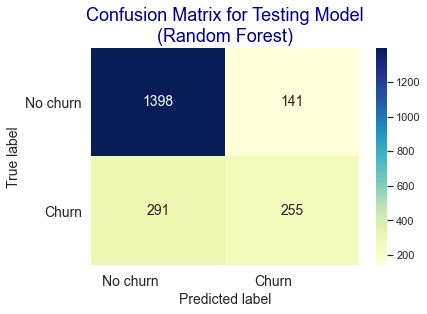

In [44]:
#Performansi Data Testing - Menampilkan Plots

#Mengubah bentuk confusion matrix menjadi DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Testing Model\n(Random Forest)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

## Gradien Boosting Classifier

In [45]:
#Train the model
gbt_model = GradientBoostingClassifier().fit(x_train,y_train)
print(gbt_model)

GradientBoostingClassifier()


In [46]:
##Performansi Data Training - Menampilkan Metrics
y_train_pred = gbt_model.predict(x_train)
print('Classification Report Training Model (Gradient Boosting):')
print(classification_report(y_train,y_train_pred))

Classification Report Training Model (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3575
           1       0.73      0.58      0.64      1290

    accuracy                           0.83      4865
   macro avg       0.79      0.75      0.77      4865
weighted avg       0.82      0.83      0.82      4865



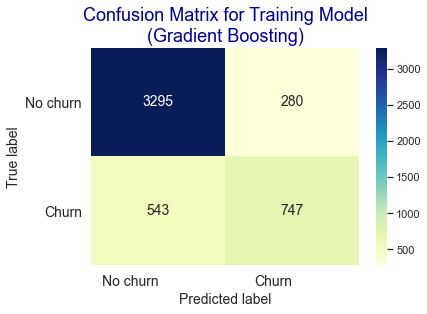

In [47]:
#Performansi Data Training - Menampilkan Plots

#Mengubah bentuk confusion matrix menjadi DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train,y_train_pred)), ('No churn','Churn'), ('No churn','Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Training Model\n(Gradient Boosting)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [48]:
#Performansi Data Testing - Menampilkan Metrics
y_test_pred = gbt_model.predict(x_test)
print('Classification Report Testing Model (Gradient Boosting):')
print(classification_report(y_test,y_test_pred))

Classification Report Testing Model (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1539
           1       0.68      0.51      0.59       546

    accuracy                           0.81      2085
   macro avg       0.76      0.71      0.73      2085
weighted avg       0.80      0.81      0.80      2085



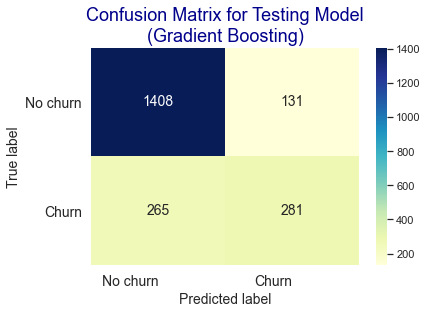

In [49]:
#Performansi Data Testing - Menampilkan Plots

#Mengubah bentuk confusion matrix menjadi DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test,y_test_pred)), ('No churn','Churn'), ('No churn','Churn'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Testing Model\n(Gradient Boosting)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()